In [125]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import StandardScaler
import numpy as np
import joblib

In [126]:
train_image_path = 'dataset/train_images.idx3-ubyte'
train_label_path = 'dataset/train_labels.idx1-ubyte'
test_image_path  = 'dataset/test_image.idx3-ubyte'
test_label_path  = 'dataset/test_label.idx1-ubyte'

In [127]:
def image_process(path_file):
    with open(path_file, 'rb') as file:
        data = np.fromfile(file, np.uint8, offset=16)
        data = data / 255
        return data.reshape(-1, 28, 28)


In [128]:
def label_process(path_file):
    with open(path_file, 'rb') as file:
        data = np.fromfile(file, np.uint8, offset=8)
        return data


In [129]:
X_train = image_process(train_image_path)
X_test  = image_process(test_image_path)
y_train = label_process(train_label_path)
y_test  = label_process(test_label_path)

In [130]:
X_train.shape , y_train.shape , X_test.shape , y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

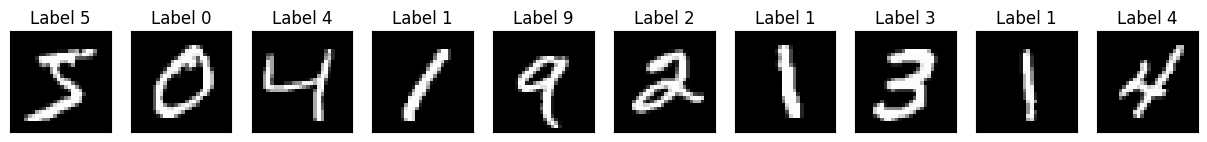

In [131]:
fig = plt.figure(figsize=(20,10))
for i in range(10):
    ax = plt.subplot(1,13,i+1)
    ax.imshow(X_train[i] , cmap='gray')
    plt.title('Label ' + str(y_train[i]))
    plt.xticks([])
    plt.yticks([])
    plt.show

# Modele 1 : K-nearest neighbors

In [134]:
class KNNClassifier:
    def euclideanDistance(self, x1, x2):
        return np.sqrt(np.sum(np.square(x1 - x2))) 
    
    def manhattanDistance(self, x1, x2):
        return np.sum(np.abs(x1 - x2))
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predect(self, k, X_test, distance='euclidean', weights='uniform'):
        y_pred = []
        
        for x in X_test:
            if distance == 'manhattan':
                distances = [self.manhattanDistance(x, x_train) for x_train in self.X_train]
            else:
                distances = [self.euclideanDistance(x, x_train) for x_train in self.X_train]
                     
            k_indices = np.argsort(distances)[:k]
            k_labels = self.y_train[k_indices]
            
            if weights == 'distance':
                y = k_labels[np.argmax(np.bincount(k_labels) * (1 / distances[k_indices]))]
                y_pred.append(y)
            else:
                y = np.argmax(np.bincount(k_labels))
                y_pred.append(y)
        
        return np.array(y_pred)    

In [135]:
# PARAMETRES 
k = 4
distance_type = 'manhattan'
weight_type = 'uniform'

# prend en petit partie du data

xpetit_train = X_train[ : 500]
ypetit_train = y_train[ : 500]

xpetit_test = X_test[ : 10]
ypetit_test = y_test[ : 10]

xpetit_train = np.reshape(xpetit_train, (xpetit_train.shape[0], -1))
train = np.reshape(ypetit_train, (ypetit_train.shape[0], -1))
xpetit_test = np.reshape(xpetit_test, (xpetit_test.shape[0], -1))
ypetit_test = np.reshape(ypetit_test, (ypetit_test.shape[0], -1))



In [136]:
model = KNNClassifier()

model.fit(xpetit_train , ypetit_train)

ypred = model.predect( k , xpetit_test, distance=distance_type, weights=weight_type)

accuracy = accuracy_score(ypetit_test, ypred)
print("Accuracy : {:.2f}%".format(accuracy * 100))

Accuracy : 80.00%


In [137]:
model = KNeighborsClassifier(n_neighbors=k)

model.fit(xpetit_train, ypetit_train)

y_pred = model.predict(xpetit_test)

accuracy = accuracy_score(ypetit_test, y_pred)
print("Accuracy : {:.2f}%".format(accuracy * 100))

Accuracy : 80.00%


# Model 2 : Logistique regression

In [138]:
class LogistiqueClssifieur:
    
    def __init__(self, alpha, iterations, normalize = True):
        self.alpha = alpha
        self.iterations = iterations    
        self.normalize = normalize    
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X_train, y_train):
        # recuperer nombre du classe 
        self.classes = np.unique(y_train)
        self.nombre_classes = len(self.classes)
        
        # pour ajouter 1 
        intercept = np.ones((X_train.shape[0], 1))
        self.X_train = X_train.reshape(X_train.shape[0] , -1)
        
        # faire normalisation
        if self.normalize :
            scaler = StandardScaler()
            scaler.fit( self.X_train)
            self.X_train = np.column_stack((intercept, scaler.transform(self.X_train)))
        else : self.X_train = np.column_stack((intercept, X_train))
        
        self.y_train = y_train.reshape(y_train.shape[0] , 1)  
        #initilaiser les thetas      
        self.theta = np.zeros((self.nombre_classes , self.X_train.shape[1]))
        # mise a jour les theta 
        self.predictMultiClasses()
            
    def derivative(self, theta , y):       
        m = len(self.X_train)
        h_theta = self.sigmoid(self.X_train @ theta.T)
        return (self.X_train.T @ (h_theta - y)).T / m    
    
    def computeCostLogistique(self, theta , y):
        m = len(self.X_train)
        h_theta = self.sigmoid(self.X_train @ theta.T )        
        h_theta[h_theta == 0.] += np.finfo(float).eps
        h_theta[h_theta == 1.] -= np.finfo(float).eps  
        return - np.sum( y.T @ np.log(h_theta) + (1 - y).T @ np.log(1 - h_theta))  / m

    def gradientDescent(self , y):
        theta_optimum = np.zeros((1 , self.X_train.shape[1]))
        theta = np.zeros((1 , self.X_train.shape[1]))
        cost_optimum = self.computeCostLogistique(theta,y)
        for i in range(self.iterations):
            delta_theta = self.derivative(theta , y)            
            theta = theta - self.alpha * delta_theta         
            cost = self.computeCostLogistique(theta, y)
            if cost_optimum > cost:
                theta_optimum = np.array(theta)
                cost_optimum = cost
        return theta_optimum
    
    def predictMultiClasses(self ):                
        for i in range(self.nombre_classes):            
            theta = self.gradientDescent( ( self.y_train == self.classes[i] ).astype(int))
            self.theta[i, :] = theta       
    
    def predict(self, X_test):
        intercept = np.ones((X_test.shape[0], 1))
        X_test = X_test.reshape(X_test.shape[0] , -1)
        if self.normalize :
            scaler = StandardScaler()
            scaler.fit(X_test)
            X_test = np.column_stack((intercept, scaler.transform(X_test)))
        else :  X_test = np.column_stack((intercept, X_test) ) 
        proba = X_test @ self.theta.T
        max_proba_classe = np.argmax(proba , axis=1)
        predect = self.classes[ max_proba_classe]
        return predect.reshape((-1, 1))

## Train and Save the model

In [139]:
#model = LogistiqueClssifieur(0.01 , 1000 , False)
#model.fit(xpetit_train, ypetit_train)
# save modele 
filename = 'LogistiqueClassifieurModel.sav'
#joblib.dump(model, filename)

In [140]:
# open model
model = joblib.load(filename)

In [141]:
ypred = model.predict(xpetit_test)
ypetit_test = ypetit_test.reshape(xpetit_test.shape[0] , 1)
accuracy = accuracy_score(ypetit_test, ypred)
print("Accuracy : {:.2f}%".format(accuracy * 100))

Accuracy : 90.00%


# Model 3 : RNN

In [142]:
def sigmoid(z):
        return 1 / (1 + np.exp(-z))    

In [143]:
w1 = np.random.uniform( -0.1 , 0.1 , size = ( 15 , 784))
b1 = np.random.uniform( -0.1, 0.1 , size=(15 , 1))
w2 = np.random.uniform( -0.1 , 0.1 , size = ( 10 , 15))
b2 = np.random.uniform( -0.1, 0.1 , size=(10 , 1))

In [144]:
def forward(X):
    a1 = sigmoid(w1 @ X.T)
    a2 = sigmoid(w2 @ a1 )
    return a1 , a2 

def backward(X , a1 , a2):
   
   dz2 = a2 - YY.T # (10 * 500)
   dw2 = dz2 @ a1.T    # 10 * 500 @ 500 * 15   =  10 * 15           
   db2 = dz2       # 10 * 500
   
   dz1 = w2.T @ dz2 * a1 * ( 1 - a1 )   
   dw1 = dz1 @ X
   db1 = dz1 
                
   db2 = np.mean(db2 , axis = 1).reshape((-1 , 1))
   db1 = np.mean(db1 , axis = 1).reshape((-1 , 1))    
   return dw1 , db1 , dw2 , db2   

def lossFunction(X , YY):
    _, ypred = forward(X)
    ypred = ypred.T
    return - np.mean( YY * np.log(ypred))
    
YY = np.zeros(( ypetit_train.shape[0] , 10 )   )  

for i in range(10):
    YY[ : , i ] = ( ypetit_train == i ).astype(int)
    
num_epochs = 10000
learning_rate = 0.001

def gradinetDescent(X , w1 , b1 , w2 , b2 ):
    
    optimale = ( w1 , b1 , w2 , b2)
    lossOptim = lossFunction(X , YY)
        
    for epoch in range(num_epochs):
        
        a1 , a2 = forward(X)
        dw1 , db1 , dw2 , db2  = backward(X , a1 , a2 )
        
        w1 -= learning_rate * dw1
        b1 -= learning_rate * db1
        w2 -= learning_rate * dw2
        b2 = learning_rate * db2
        
        
        loss = lossFunction(X , YY)
        
        if loss < lossOptim :
            optimale = ( w1 , b1 , w2 , b2) 
            lossOptim = loss
            
    return optimale 
    

In [145]:
w1 , b1 , w2 , b2 = gradinetDescent(xpetit_train , w1 , b1 , w2 , b2 )

In [146]:
def predict(X, w1, b1, w2, b2):
    _, y_pred = forward(X)
    return np.argmax(y_pred, axis=0)

y_pred = predict(xpetit_test, w1 , b1 , w2 , b2)


In [147]:
accuracy = accuracy_score(y_pred, ypetit_test)
print("Accuracy : {:.2f}%".format(accuracy * 100))

Accuracy : 90.00%
